In [1]:
import json
import webbrowser

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymoo.indicators.hv import Hypervolume

from enroads_runner import EnroadsRunner
from evolution.outcomes.outcome_manager import OutcomeManager
from generate_url import actions_to_url
from moo.problems.enroads_problem import EnroadsProblem
from moo.problems.nn_problem import NNProblem

## Setup

In [14]:
context = True
save_path = "results/pymoo/context"
with open(save_path + "/config.json", 'r') as f:
    config = json.load(f)

actions = config["actions"]
outcomes = config["outcomes"]

with open(save_path + "/results", 'rb') as f:
    res = dill.load(f)
    print("Loaded Checkpoint:", res)

X = res.X
F = res.F

# NOTE: Don't use the problem to evaluate because we might run into concurrency issues with read/write.
if not context:
    problem = EnroadsProblem(actions, outcomes)
else:
    context_df = pd.read_csv("experiments/scenarios/gdp_context.csv")
    context_df = context_df.drop(columns=["F", "scenario"])
    problem = NNProblem(context_df, {"in_size": len(context_df.columns), "hidden_size": 16, "out_size": len(actions)}, actions, outcomes)

runner = EnroadsRunner("experiments/temp")
baseline_df = runner.evaluate_actions({})
outcome_manager = OutcomeManager(list(outcomes.keys()))
baseline_metrics = outcome_manager.process_outcomes({}, baseline_df)

Loaded Checkpoint: <pymoo.core.result.Result object at 0x17531d840>
make: `enroads' is up to date.
make: `enroads' is up to date.
make: `enroads' is up to date.
make: `enroads' is up to date.


## Convergence Check

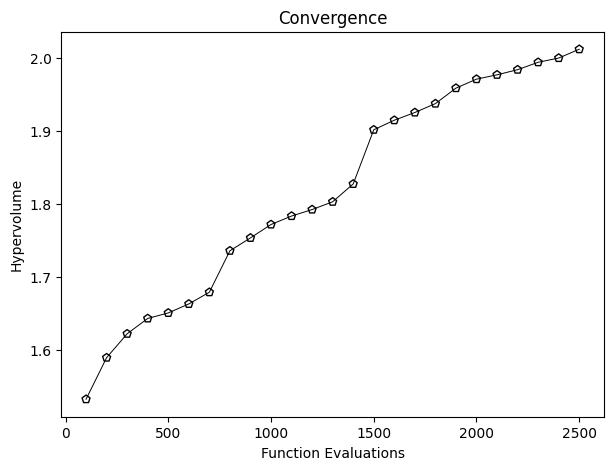

In [3]:
def extract_history(res, save_path=None):
    hist = res.history
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population
    for algo in hist:

        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)

        # retrieve the optimum from the algorithm
        opt = algo.opt

        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())

        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])
    return n_evals, hist_F, hist_cv, hist_cv_avg

n_evals, hist_F, hist_cv, hist_cv_avg = extract_history(res)

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

metric = Hypervolume(ref_point=approx_nadir+1,
                     norm_ref_point=True,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
if save_path:
    plt.savefig(save_path + "/convergence.png", dpi=300)
plt.show()

## Objectives

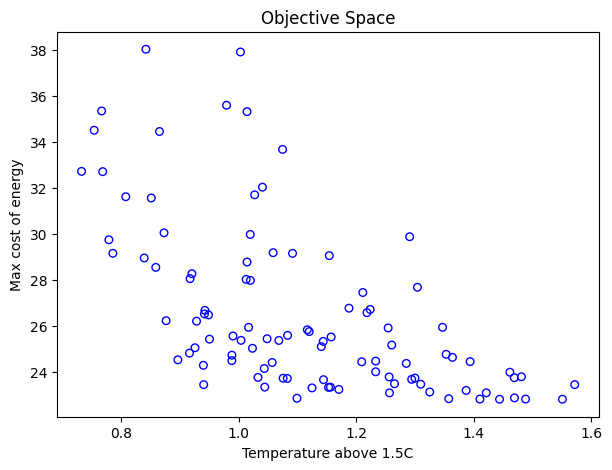

In [4]:
obj_idxs = (0, 1)
plt.figure(figsize=(7, 5))
plt.scatter(F[:, obj_idxs[0]], F[:, obj_idxs[1]], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel(list(outcomes.keys())[obj_idxs[0]])
plt.ylabel(list(outcomes.keys())[obj_idxs[1]])
plt.show()

In [5]:
sample_idxs = set()
for i in range(F.shape[1]):
    sample_idxs.add(F[:,i].argmin())
    sample_idxs.add(F[:,i].argmax())

sample_idxs = list(sample_idxs)
print(sample_idxs)
print(F[sample_idxs])

[0, 1, 2, 3, 4, 5, 6]
[[ 8.42038000e-01  3.80133000e+01 -0.00000000e+00  1.20279316e+04]
 [ 1.36360000e+00  2.46393000e+01  1.28763972e+01  5.45930140e+03]
 [ 7.32586000e-01  3.27115200e+01 -0.00000000e+00  1.62205480e+04]
 [ 1.55069800e+00  2.28229400e+01  2.18690336e+01  7.65986180e+03]
 [ 8.39148000e-01  2.89530600e+01  1.95121252e+00  1.74083470e+04]
 [ 9.42436000e-01  2.66794000e+01  1.03372000e+02  1.05992534e+04]
 [ 1.57167800e+00  2.34573000e+01  2.81635300e+00  6.89294960e+03]]


In [6]:
def evenly_sample(lst, m):
    middle = lst[1:-1]
    step = len(middle) / (m-2)
    sample = [middle[int(i * step)] for i in range(m-2)]
    sample = [lst[0]] + sample + [lst[-1]]
    return sample

sort_col_idx = 0
sample_idxs = evenly_sample(np.argsort(F[:,sort_col_idx]), 9)
print(sample_idxs)
print(F[sample_idxs])

[2, 28, 19, 49, 85, 57, 92, 62, 6]
[[ 7.32586000e-01  3.27115200e+01 -0.00000000e+00  1.62205480e+04]
 [ 7.54098000e-01  3.44966400e+01 -0.00000000e+00  1.60902482e+04]
 [ 9.16180000e-01  2.48234200e+01  2.10453643e+01  1.34250274e+04]
 [ 9.90244000e-01  2.55679200e+01  1.16204326e+01  9.71299620e+03]
 [ 1.04423600e+00  2.33480000e+01  7.03059889e+01  1.03966112e+04]
 [ 1.14048000e+00  2.51062800e+01  1.50225922e+01  7.45230000e+03]
 [ 1.23298200e+00  2.40140200e+01  1.18023452e+01  6.96363240e+03]
 [ 1.35289000e+00  2.47714400e+01 -0.00000000e+00  7.62317580e+03]
 [ 1.57167800e+00  2.34573000e+01  2.81635300e+00  6.89294960e+03]]


In [7]:
def plot_parallel_coordinates(F, outcomes, cand_idxs, save_path=None):
    coords_dicts = []
    for cand_idx in range(F.shape[0]):
        results_dict = dict(zip(outcomes.keys(), F[cand_idx]))
        if cand_idx in cand_idxs:
            print(results_dict)
        # Since we always minimize we need to flip the sign of outcomes that are maximized.
        for key in results_dict:
            if not outcomes[key]:
                results_dict[key] = -results_dict[key]
        if cand_idx in cand_idxs:
            results_dict["cand_id"] = cand_idx
        else:
            results_dict["cand_id"] = "other"
        coords_dicts.append(results_dict)

    baseline_dict = {outcome: metric for outcome, metric in baseline_metrics.items()}
    baseline_dict["cand_id"] = "Baseline"
    coords_dicts.append(baseline_dict)

    coords_df = pd.DataFrame(coords_dicts)
    normalized_df = coords_df[outcomes.keys()]
    normalized_df = (normalized_df - normalized_df.mean()) / (normalized_df.std() + 1e-10)
    normalized_df["cand_id"] = coords_df["cand_id"]
    pd.plotting.parallel_coordinates(normalized_df[normalized_df["cand_id"] == "other"], "cand_id", color=["lightgray"])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Color baseline black
    condition = (normalized_df["cand_id"] != "other") & (normalized_df["cand_id"] != "Baseline")
    pd.plotting.parallel_coordinates(normalized_df[condition], "cand_id", color=colors)

    pd.plotting.parallel_coordinates(normalized_df[normalized_df["cand_id"] == "Baseline"], "cand_id", color="black")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.ylabel("Normalized Value")
    plt.title("Parallel Coordinates of Sampled Candidates")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

{'Temperature above 1.5C': 0.732586, 'Max cost of energy': 32.71152, 'Government net revenue below zero': -0.0, 'Total energy below baseline': 16220.547999999999}
{'Temperature above 1.5C': 1.571678, 'Max cost of energy': 23.457299999999996, 'Government net revenue below zero': 2.816353, 'Total energy below baseline': 6892.9496}
{'Temperature above 1.5C': 0.91618, 'Max cost of energy': 24.82342, 'Government net revenue below zero': 21.04536426, 'Total energy below baseline': 13425.027399999997}
{'Temperature above 1.5C': 0.754098, 'Max cost of energy': 34.49664, 'Government net revenue below zero': -0.0, 'Total energy below baseline': 16090.248199999998}
{'Temperature above 1.5C': 0.9902439999999999, 'Max cost of energy': 25.567920000000004, 'Government net revenue below zero': 11.620432580000003, 'Total energy below baseline': 9712.9962}
{'Temperature above 1.5C': 1.14048, 'Max cost of energy': 25.10628, 'Government net revenue below zero': 15.022592179999998, 'Total energy below base

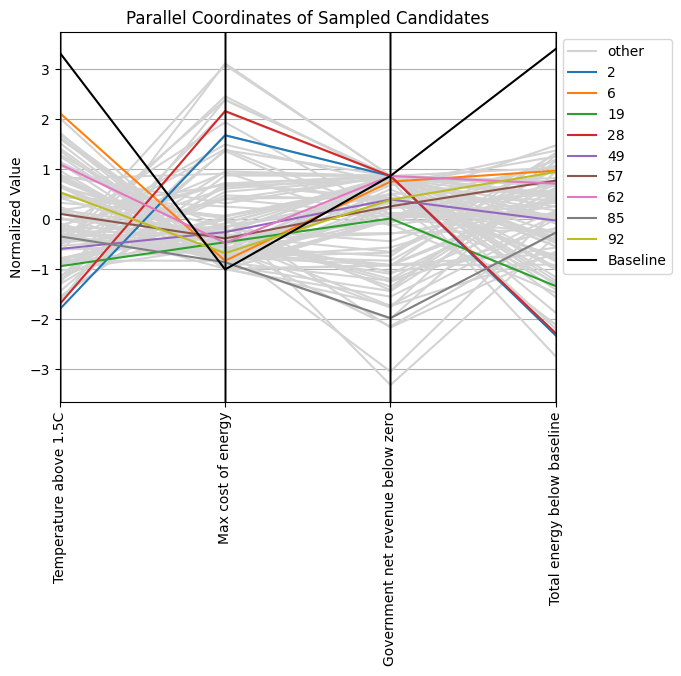

In [8]:
plot_parallel_coordinates(F, outcomes, sample_idxs, save_path=save_path + "/parallel.png")

## Outcomes

In [15]:
if not context:
    outcomes_dfs = []
    for cand_idx in range(X.shape[0]):
        actions_dict = problem.params_to_actions_dict(X[cand_idx])
        outcomes_df = runner.evaluate_actions(actions_dict)
        outcomes_dfs.append(outcomes_df)
else:
    outcomes_dfs = []
    for cand_idx in range(X.shape[0]):
        context_actions_dicts = problem.params_to_context_actions_dicts(X[cand_idx])
        cand_outcomes_dfs = problem.run_enroads(context_actions_dicts)
        # Average outcomes over all contexts
        concat_df = pd.concat(cand_outcomes_dfs, axis=0, keys=range(len(cand_outcomes_dfs)))

        # Calculate the mean, keeping NaNs
        average_df = concat_df.groupby(level=1).mean()
        outcomes_dfs.append(average_df)


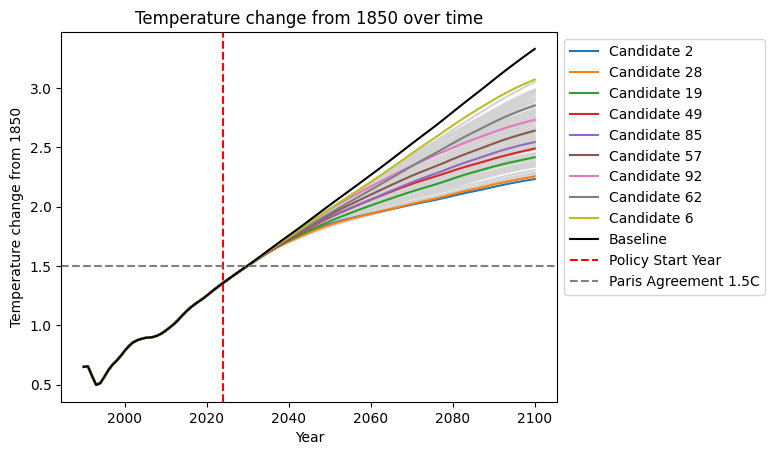

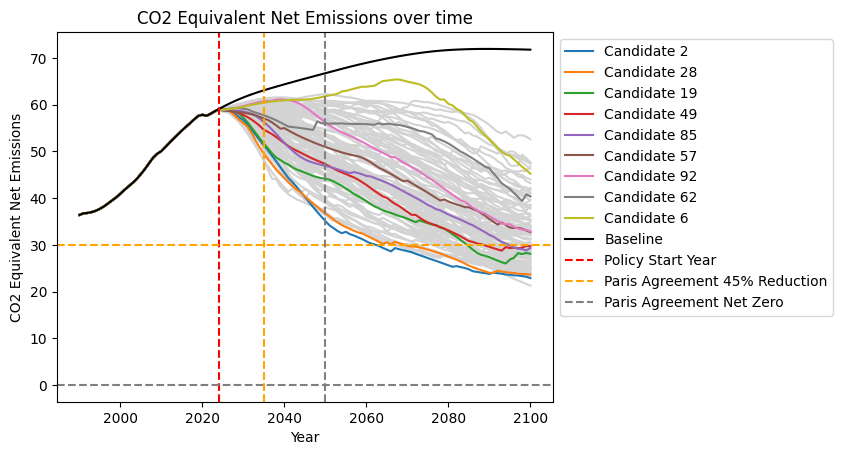

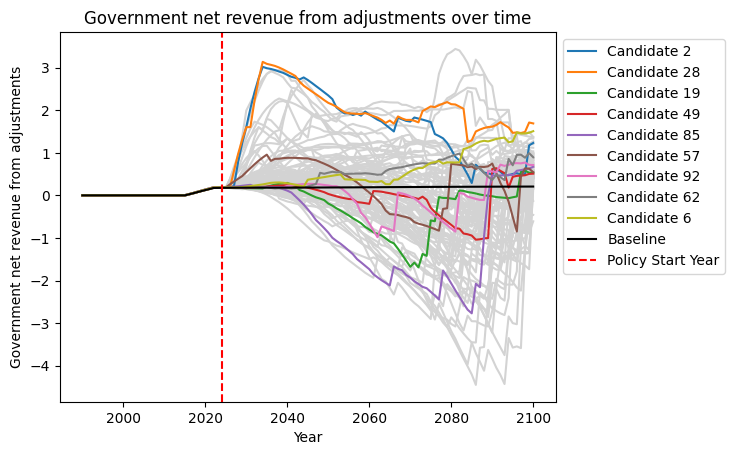

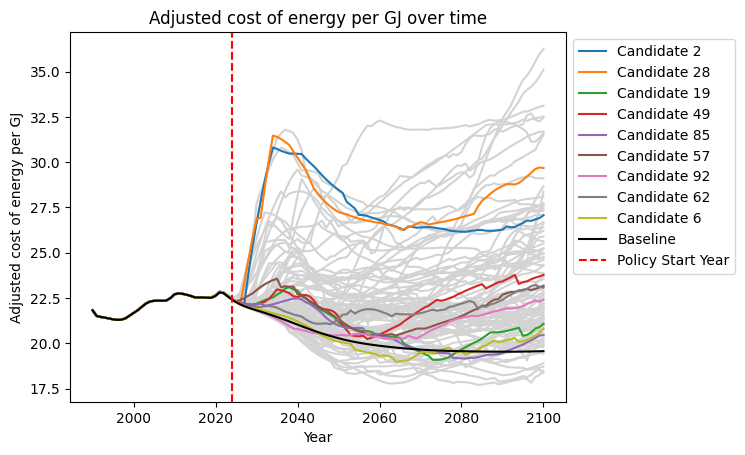

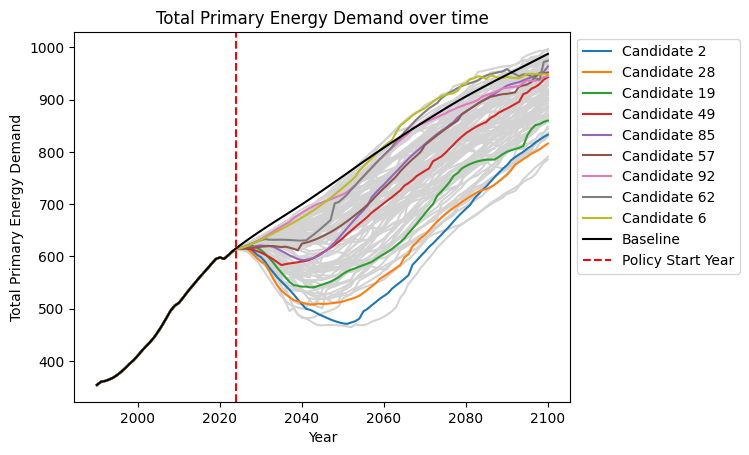

In [16]:
def plot_outcome_over_time(outcomes: list[str],
                           cand_idxs: list[int],
                           outcomes_dfs: list[pd.DataFrame],
                           baseline_df: pd.DataFrame,
                           save_path=None):
    for outcome in outcomes:
        for cand_idx in range(X.shape[0]):
            if cand_idx not in cand_idxs:
                plt.plot(range(1990, 2101), outcomes_dfs[cand_idx][outcome], color="lightgray")
        for cand_idx in cand_idxs:
            plt.plot(range(1990, 2101), outcomes_dfs[cand_idx][outcome], label=f"Candidate {cand_idx}")
        plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
        plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")

        if outcome == "CO2 Equivalent Net Emissions":
            plt.axhline(y=0, color="gray", linestyle="--")
            plt.axhline(y=54.4789*0.55, color="orange", linestyle="--", label="Paris Agreement 45% Reduction")
            plt.axvline(x=2035, color="orange", linestyle="--")
            plt.axvline(x=2050, color="gray", linestyle="--", label="Paris Agreement Net Zero")

        elif outcome == "Temperature change from 1850":
            plt.axhline(y=1.5, color="gray", linestyle="--", label="Paris Agreement 1.5C")

        plt.legend(bbox_to_anchor=(1, 1))
        plt.title(f"{outcome} over time")
        plt.xlabel("Year")
        plt.ylabel(outcome)
        if save_path:
            plt.savefig(save_path + f"/{outcome.replace(' ', '-')}.png", bbox_inches='tight', dpi=300)
        plt.show()

plot_outcomes = ["Temperature change from 1850", "CO2 Equivalent Net Emissions", "Government net revenue from adjustments", "Adjusted cost of energy per GJ", "Total Primary Energy Demand"]
plot_outcome_over_time(plot_outcomes, sample_idxs, outcomes_dfs, baseline_df, save_path=save_path)

In [17]:
def plot_energy_usage(cand_idxs: list[int], outcomes_dfs: list[pd.DataFrame], baseline_df: pd.DataFrame, save_path=None):
    fig, axes = plt.subplots(1, len(cand_idxs), sharey=True, figsize=(7.5 * len(cand_idxs), 5))
    if len(cand_idxs) == 1:
        axes = [axes]
    axes[0].set_ylabel("Energy (Exajoules / year)")
    for cand_id, ax in zip(cand_idxs, axes):
        cand_outcomes = None
        if cand_id == "baseline":
            cand_outcomes = baseline_df
        else:
            cand_outcomes = outcomes_dfs[cand_id]
        colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
        energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
        demands = [f"Primary energy demand of {energy}" for energy in energies]
        energy_df = cand_outcomes[demands]
        for i, demand in enumerate(demands):
            base = 0
            if i != 0:
                for j in range(i):
                    base += energy_df[demands[j]]
            if energy_df[demand].sum() == 0:
                continue
            ax.fill_between(range(1990, 2101), base, base + energy_df[demand], label=energies[i], color=colors[i], alpha=0.8)
        if cand_id != "baseline" and len(outcomes) > 1:
            ax.set_title(f"Average Energy Usage for Candidate {cand_id}")
        else:
            ax.set_title(f"Energy Usage for {cand_id}")
        ax.set_xlabel("Year")
        ax.axvline(x=2024, color="red", linestyle="--")

    plt.suptitle("Global Sources of Primary Energy")
    # Reverse the legend order
    plt.legend(reversed(ax.get_legend_handles_labels()[0]), reversed(ax.get_legend_handles_labels()[1]))
    if save_path:
        plt.savefig(save_path + "/energy.png", dpi=300)
    plt.show()

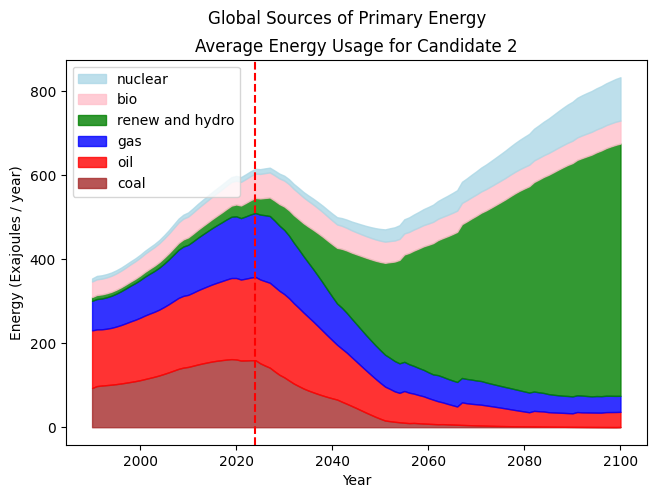

In [18]:
plot_energy_usage([2], outcomes_dfs, baseline_df)

In [ ]:
def open_idx(cand_idx: int, X: np.ndarray, problem: EnroadsProblem):
    actions_dict = problem.params_to_actions_dict(X[cand_idx])
    url = actions_to_url(actions_dict)
    webbrowser.open(url)

In [ ]:
open_idx(113, X, problem)